This Data was scrape on 10th May 2025

# Data Preparation

In [1]:
import requests as rs
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import duckdb as ddb # Using 
from bs4 import BeautifulSoup as bs

con = ddb.connect()

# Web Scraping

In [2]:
urls = [
    'https://myanimelist.net/topanime.php?type=bypopularity',
    'https://myanimelist.net/topanime.php?type=bypopularity&limit=50',
    'https://myanimelist.net/topanime.php?type=bypopularity&limit=100',
    'https://myanimelist.net/topanime.php?type=bypopularity&limit=150',
    'https://myanimelist.net/topanime.php?type=bypopularity&limit=200',
]

data = []
header = []

for url in urls:
    response = rs.get(url)
    soup = bs(response.content, 'html.parser')
    

    table = soup.find('table', class_='top-ranking-table')
    header_row = soup.find('tr', class_='table-header')
    rows = table.find_all('tr', class_='ranking-list')
    
    if header_row and not header:
        header_columns = header_row.find_all('td')
        for td in header_columns[:3]:
            header.append(td.text.strip())
        header.append('episodes')
        header.append('date_aired')
        header.append('members')
    
    for tr in rows:
        row_data = []

        # Rank
        rank = tr.find('td', class_='rank')
        row_data.append(rank.text.strip() if rank else '')

        # Title
        title_td = tr.find('td', class_='title')
        title_div = title_td.find('div', class_='di-ib clearfix') if title_td else None
        row_data.append(title_div.text.strip() if title_div else '')

        # Score
        score = tr.find('td', class_='score')
        row_data.append(score.text.strip() if score else '')

        # Episodes
        info_div = tr.find('div', class_='information di-ib mt4')
        total_eps = ''
        if info_div:
            lines = list(info_div.stripped_strings)
            total_eps = lines[0]
        row_data.append(total_eps)

        # Date
        total_date = ''
        if info_div:
            lines = list(info_div.stripped_strings)
            total_date = lines[1]
        row_data.append(total_date)
        
        # Member
        total_members = ''
        if info_div:
            lines = list(info_div.stripped_strings)
            total_members = lines[2]
        row_data.append(total_members)

        data.append(row_data)

In [3]:
print(data)

[['1', 'Shingeki no Kyojin', '8.56', 'TV (25 eps)', 'Apr 2013 - Sep 2013', '4,158,024 members'], ['2', 'Death Note', '8.62', 'TV (37 eps)', 'Oct 2006 - Jun 2007', '4,102,384 members'], ['3', 'Fullmetal Alchemist: Brotherhood', '9.10', 'TV (64 eps)', 'Apr 2009 - Jul 2010', '3,519,653 members'], ['4', 'One Punch Man', '8.49', 'TV (12 eps)', 'Oct 2015 - Dec 2015', '3,380,575 members'], ['5', 'Kimetsu no Yaiba', '8.43', 'TV (26 eps)', 'Apr 2019 - Sep 2019', '3,248,495 members'], ['6', 'Sword Art Online', '7.22', 'TV (25 eps)', 'Jul 2012 - Dec 2012', '3,196,108 members'], ['7', 'Boku no Hero Academia', '7.84', 'TV (13 eps)', 'Apr 2016 - Jun 2016', '3,167,551 members'], ['8', 'Hunter x Hunter (2011)', '9.03', 'TV (148 eps)', 'Oct 2011 - Sep 2014', '3,019,844 members'], ['9', 'Naruto', '8.01', 'TV (220 eps)', 'Oct 2002 - Feb 2007', '2,989,182 members'], ['10', 'Tokyo Ghoul', '7.79', 'TV (12 eps)', 'Jul 2014 - Sep 2014', '2,944,241 members'], ['11', 'Kimi no Na wa.', '8.83', 'Movie (1 eps)', '

# Change into DataFrame

In [4]:
df = pd.DataFrame(data, columns=header)
df

,Rank,Title,Score,episodes,date_aired,members
0,1,Shingeki no Kyojin,8.56,TV (25 eps),Apr 2013 - Sep 2013,"4,158,024 members"
1,2,Death Note,8.62,TV (37 eps),Oct 2006 - Jun 2007,"4,102,384 members"
2,3,Fullmetal Alchemist: Brotherhood,9.10,TV (64 eps),Apr 2009 - Jul 2010,"3,519,653 members"
3,4,One Punch Man,8.49,TV (12 eps),Oct 2015 - Dec 2015,"3,380,575 members"
4,5,Kimetsu no Yaiba,8.43,TV (26 eps),Apr 2019 - Sep 2019,"3,248,495 members"
...,...,...,...,...,...,...
245,246,Higurashi no Naku Koro ni,7.87,TV (26 eps),Apr 2006 - Sep 2006,"834,183 members"
246,247,InuYasha,7.87,TV (167 eps),Oct 2000 - Sep 2004,"832,555 members"
247,248,High School DxD BorN,7.41,TV (12 eps),Apr 2015 - Jun 2015,"829,886 members"
248,249,Owari no Seraph: Nagoya Kessen-hen,7.61,TV (12 eps),Oct 2015 - Dec 2015,"827,338 members"


# Data Cleaning

Changing Episodes into 2 columns, which is Episodes and Release_Type

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Rank        250 non-null    object
 1   Title       250 non-null    object
 2   Score       250 non-null    object
 3   episodes    250 non-null    object
 4   date_aired  250 non-null    object
 5   members     250 non-null    object
dtypes: object(6)
memory usage: 11.8+ KB


Change Score type into float

In [6]:
df.isnull().sum()

Rank          0
Title         0
Score         0
episodes      0
date_aired    0
members       0
dtype: int64

In [7]:
df['Score'] = df['Score'].astype(float)

In [8]:
df[['release_type', 'episodes']] = df['episodes'].str.extract(r'^(.*?)\s*\(([^)]+)\s+eps\)')

Regex Breakdown: `r'^(.*?)\s*\(([^)]+)\s+eps\)'`

```regex
^         # Start of the string
(.*?)     # 1st Capture Group: Lazily matches any characters (release type like "TV" or "Movie")
\s*       # Matches optional whitespace (space/tab) after the release type
\(        # Escaped parenthesis: Matches literal '(' character
([^)]+)   # 2nd Capture Group: Matches 1+ characters that are NOT ')'
\s+eps    # Matches whitespace followed by "eps"
\)        # Escaped parenthesis: Matches literal ')' character

In [9]:
df['episodes'].unique()

array(['25', '37', '64', '12', '26', '13', '148', '220', '1', '24', '500',
       '?', '10', '22', '16', '366', '175', '170', '51', '27', '11', '23',
       '15', '291', '74', '20', '39', '120', '201', '28', '153', '102',
       '3', '14', '293', '131', '43', '7', '6', '167'], dtype=object)

Find episodes that has the value '?'

In [10]:
find_error = con.execute("SELECT * FROM df WHERE Episodes = '?'").fetchdf()

In [11]:
find_error

,Rank,Title,Score,episodes,date_aired,members,release_type
0,17,One Piece,8.73,?,Oct 1999 -,"2,527,977 members",TV


Because One Piece is still on going, I'm changing it into 9999, also because to change into integer type

In [12]:
df['episodes'] = df['episodes'].str.replace('?', '9999')

In [13]:
df['episodes'] = pd.to_numeric(df['episodes'], errors='coerce')

Changing date_aired into 2 dates which is the date_aired and date_ended

In [14]:
df[['date_aired', 'date_ended']] = df['date_aired'].str.split(' - ', expand=True).apply(lambda x: x.str.strip())

In [15]:
df.head()

,Rank,Title,Score,episodes,date_aired,members,release_type,date_ended
0,1,Shingeki no Kyojin,8.56,25,Apr 2013,"4,158,024 members",TV,Sep 2013
1,2,Death Note,8.62,37,Oct 2006,"4,102,384 members",TV,Jun 2007
2,3,Fullmetal Alchemist: Brotherhood,9.10,64,Apr 2009,"3,519,653 members",TV,Jul 2010
3,4,One Punch Man,8.49,12,Oct 2015,"3,380,575 members",TV,Dec 2015
4,5,Kimetsu no Yaiba,8.43,26,Apr 2019,"3,248,495 members",TV,Sep 2019


Changing both date_aired and date_ended into month and year in their respective parts

In [16]:
df[['month_aired', 'year_aired']] = df['date_aired'].str.strip().str.split(n=1, expand=True)

In [17]:
df[['month_ended', 'year_ended']] = df['date_ended'].str.strip().str.split(n=1, expand=True)

In [18]:
df.isnull().sum()

Rank            0
Title           0
Score           0
episodes        0
date_aired      0
members         0
release_type    0
date_ended      1
month_aired     0
year_aired      0
month_ended     1
year_ended      1
dtype: int64

In [19]:
df.head()

,Rank,Title,Score,episodes,date_aired,members,release_type,date_ended,month_aired,year_aired,month_ended,year_ended
0,1,Shingeki no Kyojin,8.56,25,Apr 2013,"4,158,024 members",TV,Sep 2013,Apr,2013,Sep,2013
1,2,Death Note,8.62,37,Oct 2006,"4,102,384 members",TV,Jun 2007,Oct,2006,Jun,2007
2,3,Fullmetal Alchemist: Brotherhood,9.10,64,Apr 2009,"3,519,653 members",TV,Jul 2010,Apr,2009,Jul,2010
3,4,One Punch Man,8.49,12,Oct 2015,"3,380,575 members",TV,Dec 2015,Oct,2015,Dec,2015
4,5,Kimetsu no Yaiba,8.43,26,Apr 2019,"3,248,495 members",TV,Sep 2019,Apr,2019,Sep,2019


For the One Piece, we need to remove '-' from the date_aired nad year_aired so that they can be split into 2 columns without any Errors

In [20]:
df.iloc[16]

Rank                           17
Title                   One Piece
Score                        8.73
episodes                     9999
date_aired             Oct 1999 -
members         2,527,977 members
release_type                   TV
date_ended                   None
month_aired                   Oct
year_aired                 1999 -
month_ended                  None
year_ended                   None
Name: 16, dtype: object

In [21]:
df['date_aired'] = df['date_aired'].str.replace('-', '', regex=False).str.strip()

In [22]:
df['year_aired'] = df['year_aired'].str.replace('-', '', regex=False).str.strip()

In [23]:
df['year_aired'] = pd.to_numeric(df['year_aired'], errors='coerce')

In [24]:
df['year_ended'] = pd.to_numeric(df['year_ended'], errors='coerce')
df['year_ended'] = df['year_ended'].fillna(9999).astype(int)

Remove the string 'members' from the columns, so that it only containes the numbers

In [25]:
df['members'] = df['members'].str.replace(' members', '', regex=False)

In [26]:
df['members'] = df['members'].str.replace('[^0-9]', '', regex=True).astype(int)

In [27]:
df.head()

,Rank,Title,Score,episodes,date_aired,members,release_type,date_ended,month_aired,year_aired,month_ended,year_ended
0,1,Shingeki no Kyojin,8.56,25,Apr 2013,4158024,TV,Sep 2013,Apr,2013,Sep,2013
1,2,Death Note,8.62,37,Oct 2006,4102384,TV,Jun 2007,Oct,2006,Jun,2007
2,3,Fullmetal Alchemist: Brotherhood,9.10,64,Apr 2009,3519653,TV,Jul 2010,Apr,2009,Jul,2010
3,4,One Punch Man,8.49,12,Oct 2015,3380575,TV,Dec 2015,Oct,2015,Dec,2015
4,5,Kimetsu no Yaiba,8.43,26,Apr 2019,3248495,TV,Sep 2019,Apr,2019,Sep,2019


# Data Visualization

Top 250 Anime List That Released per Year 

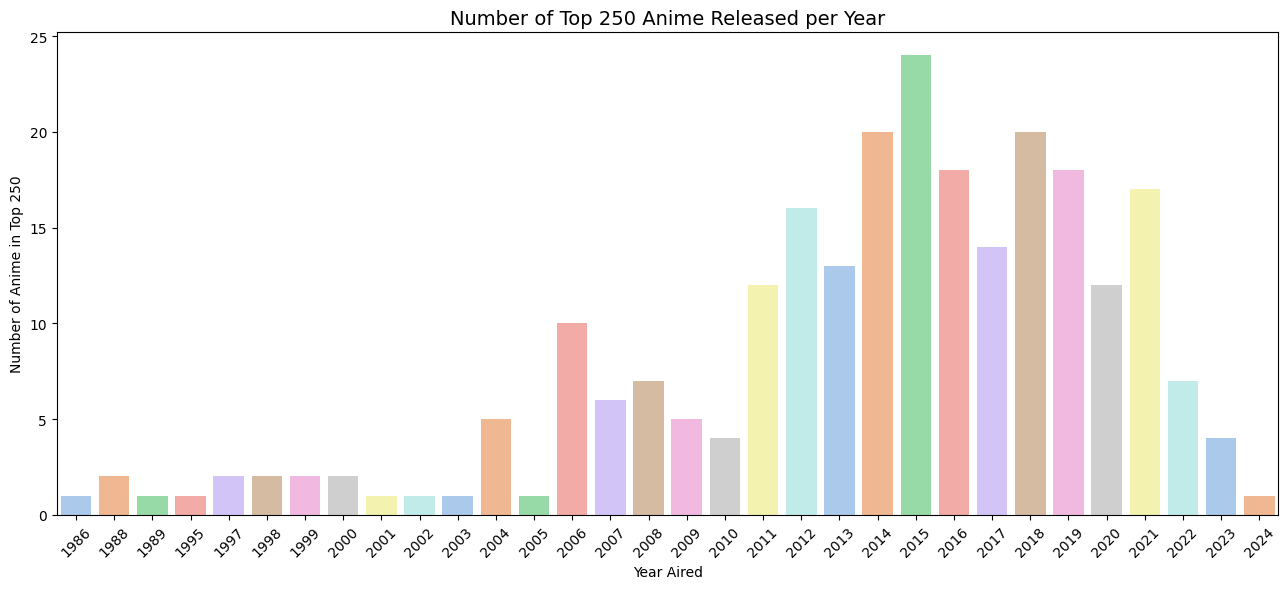

In [36]:
# Clean year_aired
df['year_aired'] = pd.to_numeric(df['year_aired'], errors='coerce')
df_clean = df.dropna(subset=['year_aired'])  # remove NaNs
df_clean['year_aired'] = df_clean['year_aired'].astype(int)

# Count and plot
top_anime_per_year = df['year_aired'].value_counts().sort_index()

df_plot = pd.DataFrame({
    'year': top_anime_per_year.index,
    'count': top_anime_per_year.values
})

plt.figure(figsize=(13, 6))
sns.barplot(data=df_plot, x='year', y='count', hue='year', palette='pastel', dodge=False, legend=False)

plt.title('Number of Top 250 Anime Released per Year', fontsize=14)
plt.xlabel('Year Aired')
plt.ylabel('Number of Anime in Top 250')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Visualization: Top 250 Anime by Release Type

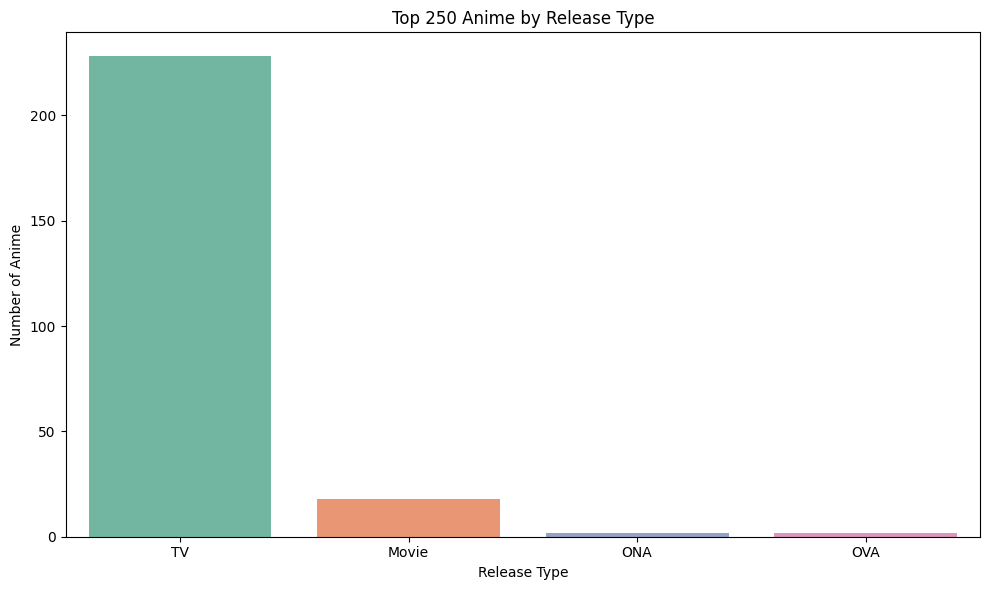

In [33]:
df_clean = df.dropna(subset=['release_type'])

# Count per release_type
release_counts = df_clean['release_type'].value_counts().reset_index()
release_counts.columns = ['release_type', 'count']

# Plot with a color palette
plt.figure(figsize=(10, 6))
sns.barplot(data=release_counts, x='release_type', y='count', hue='release_type', palette='Set2')

plt.title('Top 250 Anime by Release Type')
plt.xlabel('Release Type')
plt.ylabel('Number of Anime')
plt.tight_layout()
plt.show()

# Data Export

In [28]:
df_final = df.reindex(columns=['Rank', 'Title', 'Score', 'release_type', 'episodes', 'month_aired', 'year_aired', 'month_ended', 'year_ended', 'members'])

In [30]:
df_final.to_excel("result_scraping_anime_top_ranking.xlsx",index=False)

In [31]:
df_final.head()

,Rank,Title,Score,release_type,episodes,month_aired,year_aired,month_ended,year_ended,members
0,1,Shingeki no Kyojin,8.56,TV,25,Apr,2013,Sep,2013,4158024
1,2,Death Note,8.62,TV,37,Oct,2006,Jun,2007,4102384
2,3,Fullmetal Alchemist: Brotherhood,9.10,TV,64,Apr,2009,Jul,2010,3519653
3,4,One Punch Man,8.49,TV,12,Oct,2015,Dec,2015,3380575
4,5,Kimetsu no Yaiba,8.43,TV,26,Apr,2019,Sep,2019,3248495
